# Weight Initialization

This notebook show different weight initialize methods

In [1]:
# Steup stuff
import matplotlib.pyplot as plt
import numpy as np

## The problem with naive initialization of weights

The input to a neuron in the first layer of a neural network looks like: 

$$in = X_1 W_1 + X_2 W_2 + X_3 W_3 + X_4 W_4 ... = \sum_i^n X_i W_i$$


The variance of each element in this sum can be explained by the product of independent variables law:

$$var(X_i W_i) = [E(X_i)]^2\ var(W_i) + [E(W_i)]^2\ var(X_i) + var(X_i)\ var(W_i)$$

If we assume that the input has been appropriatly sclaed with a mean of 0 and a unit variance, and likewise we initialize the weights for a mean 0 and unit variance, then the result is:

$$var(X_i W_i) = 0 \cdot 1 + 0 \cdot 1 + 1 \cdot 1 = 1$$

So each product within the total sum of *in* has a variance of 1.

The total variance of the node input variable *in* is, under the assumption that each product is statistically independent an by applying the sum of uncorrelated independent variables law:

$$var(in) = \sum_{i=0}^n var(X_i W_i) = n \cdot 1 = n$$

Where *n* is the number of inputs. With an input of 784 the variance will be large and the standard deviation will be $\sqrt{(var(in))} = \sqrt{(784)} = 28$. This will result in the vast majority of neurons in the first layer being saturated, as most values will be $>> |2|$.

### Tanh and its derivative

/mnt/sdb1/Anaconda/envs/BScPRO/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


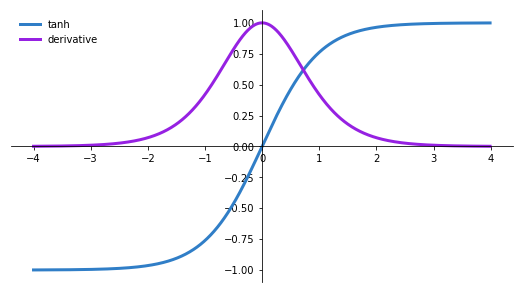

In [2]:
def tanh(z):
    ez = np.exp(z)
    enz = np.exp(-z)
    return (ez - enz)/ (ez + enz)

# Calculate plot points
z = np.arange(-4., 4., 0.01)
a = tanh(z)
dz = 1 - a**2

# Setup centered axes
fig, ax = plt.subplots(figsize=(9, 5))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Create and show plot
ax.plot(z,a, color="#307EC7", linewidth=3, label="tanh")
ax.plot(z,dz, color="#9621E2", linewidth=3, label="derivative")
ax.legend(loc="upper left", frameon=False)
fig.show()

## Activations Statistics

Example given is a 10 layer network with 500 neurons on each layer, using tanh non-linearites.

In [2]:
# assume some unit gaussian 10-D input data
D = np.random.randn(1000, 500)
hidden_layer_sizes = [500] * 10
nonlinearities = ['tanh'] * len(hidden_layer_sizes)

### Small random numbers

Gaussian with zero mean and 0.01 standard deviation

**Layer initialization:** W = np.random.randn(fan_in, fan_out) * 0.01

In [4]:
act = {'relu':lambda x:np.maximum(0, x), 'tanh':lambda x:np.tanh(x)}
Hs = []
for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    W = np.random.randn(fan_in, fan_out) * 0.01 # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.001244 and std 1.000570
Hidden layer 1 had mean -0.000033 and std 0.213255
Hidden layer 2 had mean -0.000083 and std 0.047824
Hidden layer 3 had mean -0.000007 and std 0.010718
Hidden layer 4 had mean -0.000002 and std 0.002403
Hidden layer 5 had mean -0.000001 and std 0.000540
Hidden layer 6 had mean 0.000000 and std 0.000121
Hidden layer 7 had mean 0.000000 and std 0.000027
Hidden layer 8 had mean -0.000000 and std 0.000006
Hidden layer 9 had mean 0.000000 and std 0.000001
Hidden layer 10 had mean 0.000000 and std 0.000000


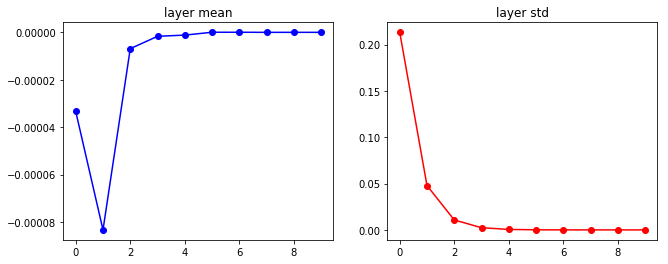

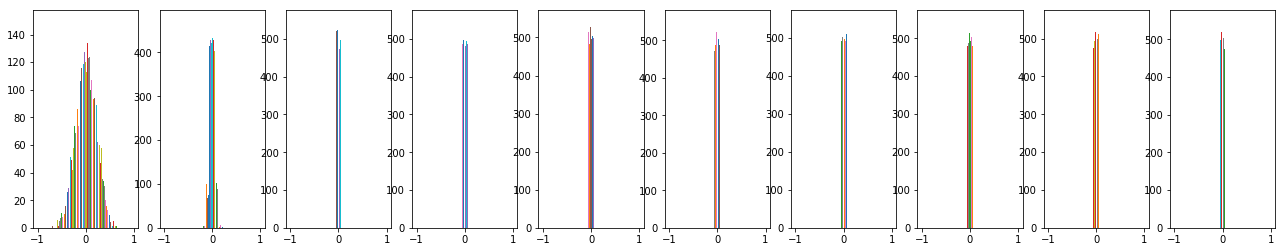

In [5]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), i+1)
    plt.hist(H, 30, range=(-1.0, 1.0))

All activations become zero! This becomes a problem for the backward pass, becuase X is small the weights are getting a very small gradient and basically not updating.

### Random values scaled by 1.0

**Layer initialization:** W = np.random.randn(fan_in, fan_out) * 1.0

In [6]:
act = {'relu':lambda x:np.maximum(0, x), 'tanh':lambda x:np.tanh(x)}
Hs = []
for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    W = np.random.randn(fan_in, fan_out) * 1.0 # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.001244 and std 1.000570
Hidden layer 1 had mean 0.002034 and std 0.981968
Hidden layer 2 had mean 0.000214 and std 0.981543
Hidden layer 3 had mean 0.000868 and std 0.981678
Hidden layer 4 had mean -0.000082 and std 0.981661
Hidden layer 5 had mean -0.000643 and std 0.981772
Hidden layer 6 had mean 0.000285 and std 0.981583
Hidden layer 7 had mean 0.000033 and std 0.981696
Hidden layer 8 had mean 0.001227 and std 0.981661
Hidden layer 9 had mean -0.000856 and std 0.981945
Hidden layer 10 had mean 0.002806 and std 0.981791


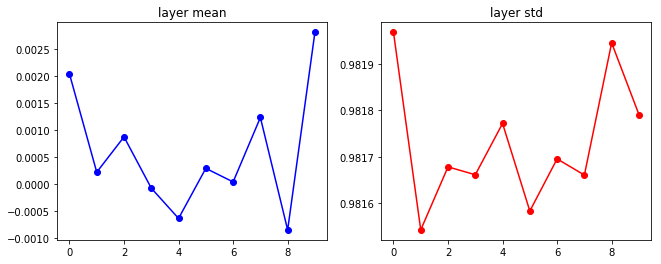

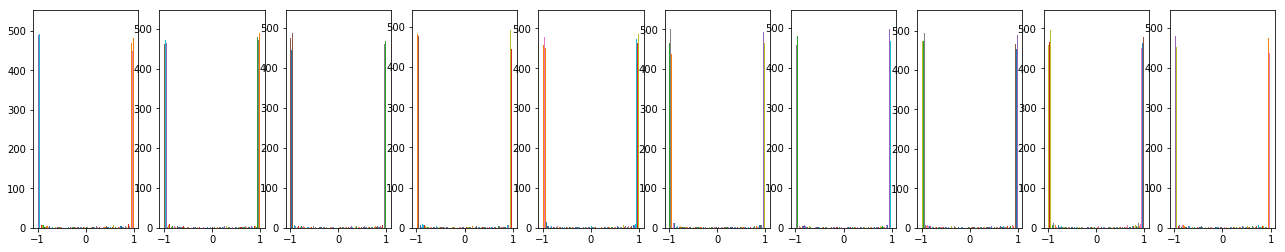

In [7]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), i+1)
    plt.hist(H, 30, range=(-1.0, 1.0))

Almost all neurons completely saturated, either -1 and 1. Gradients will be all zero. Because the weights are going to be big, tanh is always going to be at its saturated regimes of either very negative or very positive. When the tanh is saturated all the gradients will be zero and the weights will not be updating.

## Xavier or variance scaling for weight initialization

### Xavier Normal

The activation function can be approximated by a linear activation, i.e:

$$ Y = W_1 X_1 + W_2 X_2 + W_3 X_3 + ... $$

Because of the linear activation function, the same result that was arrived at above, using the product of independent variables and sum of uncorrelated independent variables, can be used:

$$var(Y) = n_{in}\ var(W_i)\ var(X_i)$$

Where $n_{in}$ is the number of inputs to each node. If the variance of the input, $var(X_i)$, shall be equal to the variance of the output, $var(Y)$, $var(W_i)$ is reduced to $\frac{1}{n_{in}}$.

Which is a preliminary result for a good initialization varience for the weights in a network. However, this is just keeping the variance constant during the forward pass. To keep the variance constant during the backpropagation the variancen must also depend on the number of ouputs, $var(W_i) = \frac{1}{n_{out}}$.

The authors of the original paper on Xavier initialization takes the average of the two:

$$n_{avg} = \frac{n_{in} + n_{out}}{2} \Rightarrow var(W_i) = \frac{1}{n_{avg}} = \frac{2}{n_{in} + n_{out}}$$

**Layer initialization:** W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in)

In [8]:
act = {'relu':lambda x:np.maximum(0, x), 'tanh':lambda x:np.tanh(x)}
Hs = []
for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    fan_in = X.shape[1]
    fan_out = hidden_layer_sizes[i]
    W = np.random.randn(fan_in, fan_out) / np.sqrt(fan_in) # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.001244 and std 1.000570
Hidden layer 1 had mean 0.001479 and std 0.627579
Hidden layer 2 had mean -0.000104 and std 0.486243
Hidden layer 3 had mean 0.000846 and std 0.407778
Hidden layer 4 had mean -0.000227 and std 0.358278
Hidden layer 5 had mean -0.000704 and std 0.322133
Hidden layer 6 had mean -0.000116 and std 0.295841
Hidden layer 7 had mean -0.000525 and std 0.274198
Hidden layer 8 had mean 0.000206 and std 0.256523
Hidden layer 9 had mean 0.000188 and std 0.242535
Hidden layer 10 had mean 0.000540 and std 0.228306


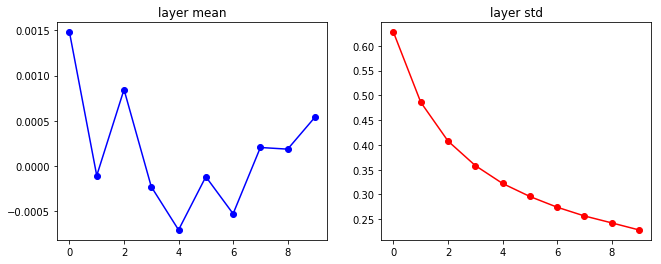

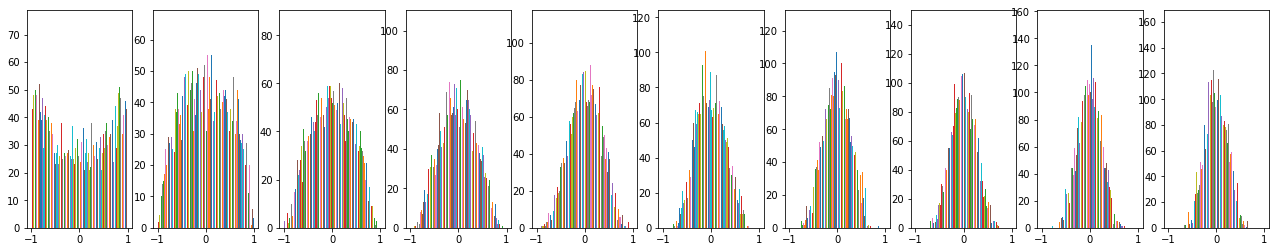

In [9]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), i+1)
    plt.hist(H, 30, range=(-1.0, 1.0))

This implementation sample from a standard gaussian and then scales byt the number of inputs. Thereby, specifing that the variance of the input shall be the same as the variance of the output. In the case above the goal is to have a unit gaussian as input to each layer, which apprximately is acheived.

### Xavier Uniform

**Layer initialization:** W = np.random.randn(fan_in, fan_out) * 
np.sqrt(6 / (fan_in + fan_out))

In [10]:
act = {'relu':lambda x:np.maximum(0, x), 'tanh':lambda x:np.tanh(x)}
Hs = []
fan_in = X.shape[1]
fan_out = hidden_layer_sizes[i]
limit = np.sqrt(6 / (fan_in + fan_out))

for i, _ in enumerate(hidden_layer_sizes):
    X = D if i == 0 else Hs[i-1] # Input layer
    W = np.random.randn(fan_in, fan_out) * limit # Layer initialization

    H = np.dot(X, W) # Matrix multiply
    H = act[nonlinearities[i]](H) # Nonlinearity
    Hs.append(H) # Cache results on this layer

Input layer had mean 0.001244 and std 1.000570
Hidden layer 1 had mean -0.001219 and std 0.768222
Hidden layer 2 had mean -0.000734 and std 0.706408
Hidden layer 3 had mean 0.000857 and std 0.684294
Hidden layer 4 had mean 0.001514 and std 0.675167
Hidden layer 5 had mean -0.000219 and std 0.671898
Hidden layer 6 had mean 0.000825 and std 0.670104
Hidden layer 7 had mean -0.000491 and std 0.668644
Hidden layer 8 had mean 0.000551 and std 0.668678
Hidden layer 9 had mean 0.001466 and std 0.667304
Hidden layer 10 had mean 0.000545 and std 0.668730


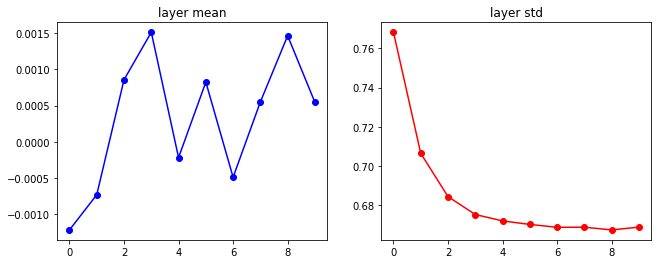

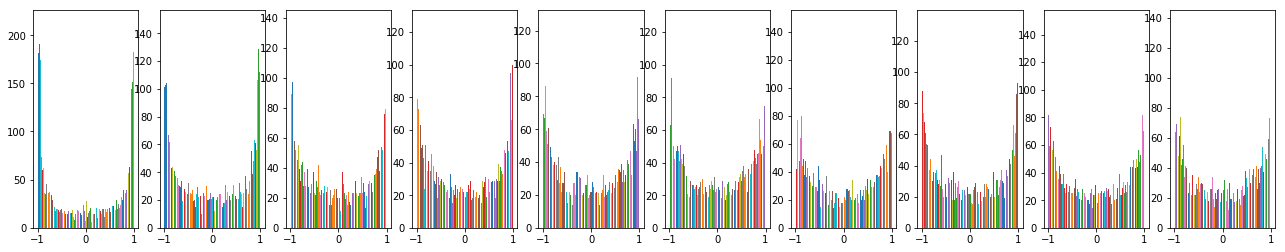

In [11]:
# Look at distributions at each layer
print('Input layer had mean %f and std %f' % (np.mean(D), np.std(D)))
layer_means = [np.mean(H) for H in Hs]
layer_stds = [np.std(H) for H in Hs]
for i, H in enumerate(Hs):
    print('Hidden layer %d had mean %f and std %f' % ((i+1), layer_means[i], layer_stds[i]))

# Plot the means and standard deviations
plt.figure()
plt.subplots_adjust(left=0.125, right=1.5)
plt.subplot(1, 2, 1)
plt.plot(range(len(Hs)), layer_means, 'ob-')
plt.title('layer mean')
plt.subplot(1, 2, 2)
plt.plot(range(len(Hs)), layer_stds, 'or-')
plt.title('layer std')

# Plot the raw distributions
plt.figure()
plt.subplots_adjust(left=0.125, right=3)
for (i, H) in enumerate(Hs):
    plt.subplot(1, len(Hs), i+1)
    plt.hist(H, 30, range=(-1.0, 1.0))